<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/Seq2Seq-Workshop/blob/master/notebooks/translate_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Translation
A sequence-to-sequence model is a model that takes a sequence of items and outputs another sequence of items using two networks that are trained end-to-end. This is perfect for machine translation since input sequences are directly related to output sequences. We will looking at preparing a dataset for Machine Translation task and implementing a seq2seq model. We will be using the parallel corpus available from [here](ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz) 

### Concepts covered here:
- Encoder-Decoder architecture: We will be using a encoder to encode input sequences from one language in a latent space and use the encoding to generate words in the target language one token at a time. The encoder and the decoder are an RNNs. 

- Attention: We will be looking at the attention mechanism described in [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf). We will explore the theory, the intuition behind it and how to move from theory and intuition to implementation.

In [0]:
%matplotlib inline
from pathlib import Path
import re,string
import numpy as np

In [0]:
!mkdir data

In [0]:
path = Path('data')

We will need to download the translation corpus and install a tokenizer for Japanese text.

In [0]:
#get corpus
#!wget ftp://ftp.monash.edu/pub/nihongo/examples.utf.gz
#decompress it and move it to data folder
#!gunzip examples.utf.gz
#!mv examples.utf data/
#install dependencies for mecab tokenizer
#!sudo apt install swig
#!sudo apt install mecab
#!sudo apt install libmecab-dev
#!sudo apt install mecab-ipadic-utf8
#!sudo pip3 install mecab-python3

In [8]:
corpus = (path/'examples.utf').open().readlines()
corpus[:5]

['A: ムーリエルは２０歳になりました。\tMuiriel is 20 now.#ID=1282_4707\n',
 'B: は 二十歳(はたち){２０歳} になる[01]{になりました}\n',
 'A: すぐに戻ります。\tI will be back soon.#ID=1284_4709\n',
 'B: 直ぐに{すぐに} 戻る{戻ります}\n',
 'A: すぐに諦めて昼寝をするかも知れない。\tI may give up soon and just nap instead.#ID=1300_4727\n']

In [0]:
def make_corpus(corpus_path):
    corpus = corpus_path.open().readlines()
    en,ja = [],[]
    pat = r'#ID.+\n'
    for c in corpus:
        if 'A: ' in c:
            clean_c = c.replace('A: ','')
            res = re.search(pat,clean_c)
            clean_c = clean_c.replace(res.group(0),'').split('\t')
            ja.append(clean_c[0])
            en.append(clean_c[1])
    return en,ja

In [10]:
en, ja = make_corpus(path/'examples.utf')
en[:2],ja[:2]

(['Muiriel is 20 now.', 'I will be back soon.'],
 ['ムーリエルは２０歳になりました。', 'すぐに戻ります。'])

In [0]:
import MeCab

In [0]:
tagger = MeCab.Tagger('-Owakati')

def ja_tokenizer(text):
    result = tagger.parse(text)
    words = result.split()
    if len(words) ==0: return []
    if words[-1] == '\n':return words[:-1]
    return words

In [13]:
ja_tokenizer(ja[0])

['ムーリエル', 'は', '２', '０', '歳', 'に', 'なり', 'まし', 'た', '。']

In [0]:
import spacy
from spacy.symbols import ORTH

In [0]:
en_tok = spacy.load('en')

In [0]:
def en_tokenizer(text):
    text = text.lower()
    return [t.text for t in en_tok.tokenizer(text)]

In [17]:
en_tokenizer(en[0])

['muiriel', 'is', '20', 'now', '.']

In [18]:
en_toks = [en_tokenizer(text) for text in en]
ja_toks = [ja_tokenizer(text) for text in ja]
en_toks[:2], ja_toks[:2]

([['muiriel', 'is', '20', 'now', '.'],
  ['i', 'will', 'be', 'back', 'soon', '.']],
 [['ムーリエル', 'は', '２', '０', '歳', 'に', 'なり', 'まし', 'た', '。'],
  ['すぐ', 'に', '戻り', 'ます', '。']])

In [19]:
len(en_toks), len(ja_toks)

(149785, 149785)

In [0]:
from collections import Counter,defaultdict

In [0]:
def numericalize_tok(tokens, max_vocab=50000, min_freq=3, unk_tok="xxunk", pad_tok="xxpad", bos_tok="xxbos", eos_tok="xxeos"):
    if isinstance(tokens, str):
        raise ValueError("Expected to receive a list of tokens. Received a string instead")
    if isinstance(tokens[0], list):
        tokens = [p for o in tokens for p in o]
    freq = Counter(tokens)
    int2tok = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
    unk_id = 3
    int2tok.insert(0, bos_tok)
    int2tok.insert(1, pad_tok)
    int2tok.insert(2, eos_tok)
    int2tok.insert(unk_id, unk_tok)
    tok2int = defaultdict(lambda:unk_id, {v:k for k,v in enumerate(int2tok)})
    return int2tok, tok2int

In [0]:
int2j,j2int = numericalize_tok(ja_toks)
int2en,en2int = numericalize_tok(en_toks)

In [26]:
len(int2j), len(int2en)

(12677, 9290)

In [0]:
import pickle

In [0]:
pickle.dump(int2j,(path/'int2j.pkl').open('wb'))
pickle.dump(int2en,(path/'int2en.pkl').open('wb'))

In [0]:
int2j = pickle.load((path/'int2j.pkl').open('rb'))
int2en = pickle.load((path/'int2en.pkl').open('rb'))
j2int = defaultdict(lambda:3, {v:k for k,v in enumerate(int2j)})
en2int = defaultdict(lambda:3, {v:k for k,v in enumerate(int2en)})

In [28]:
len(int2j), len(int2en)

(12677, 9290)

In [29]:
j_ids = np.array([[0]+[j2int[o] for o in sent]+[2] for sent in ja_toks])
en_ids = np.array([[0]+[en2int[o] for o in sent]+[2] for sent in en_toks])
len(j_ids),len(en_ids), j_ids[10],en_ids[10]

(149785,
 149785,
 [0,
  48,
  6,
  4891,
  5,
  109,
  11,
  143,
  10,
  83,
  8,
  57,
  86,
  1798,
  7,
  2146,
  232,
  255,
  47,
  36,
  4,
  2],
 [0, 114, 2251, 107, 38, 97, 85, 2649, 77, 28, 356, 4, 2])

In [0]:
np.random.seed(42)

In [31]:
trn_keep = np.random.rand(len(en_ids))>0.1
en_trn,j_trn = en_ids[trn_keep],j_ids[trn_keep]
en_val,j_val = en_ids[~trn_keep],j_ids[~trn_keep]
len(en_trn),len(en_val)

(134774, 15011)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd.variable import Variable
from torch.utils.data import Dataset,DataLoader

In [0]:
from numpy import array as A

In [0]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx]), A(self.y[idx])
    def __len__(self): return len(self.x)

In [0]:
trn_ds = Seq2SeqDataset(en_trn,j_trn)
val_ds = Seq2SeqDataset(en_val,j_val)

bs = 120

trn_dl = DataLoader(trn_ds,batch_size=bs,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=bs)

In [0]:
x, y = next(iter(val_dl))
x.size(), y.size()

(torch.Size([120, 25]), torch.Size([120, 25]))

In [36]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [38]:
enlen_90 = int(np.percentile([len(o) for o in en_ids], 99))
jalen_90 = int(np.percentile([len(o) for o in j_ids], 99))
enlen_90,jalen_90

(25, 29)

In [0]:
j_ids = pad_sequences(j_ids, maxlen=29, dtype='int32', padding='post', truncating='post', value=1)
en_ids = pad_sequences(en_ids, maxlen=25, dtype='int32', padding='post', truncating='post', value=1)

In [40]:
trn_keep = np.random.rand(len(en_ids))>0.1
en_trn,j_trn = en_ids[trn_keep],j_ids[trn_keep]
en_val,j_val = en_ids[~trn_keep],j_ids[~trn_keep]
len(en_trn),len(en_val)

(134746, 15039)

In [0]:
trn_ds = Seq2SeqDataset(en_trn,j_trn)
val_ds = Seq2SeqDataset(en_val,j_val)

bs = 120

trn_dl = DataLoader(trn_ds,batch_size=bs,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=bs)

In [42]:
x, y = next(iter(val_dl))
x.size(), y.size()

(torch.Size([120, 25]), torch.Size([120, 29]))

In [0]:
## load fasttext vectors
#code from here:https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    header = fin.readline().split()
    n, d = int(header[0]), int(header[1])
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=float)
    return data, int(n), int(d)

In [44]:
# get word vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ja.300.vec.gz
!unzip wiki-news-300d-1M.vec.zip
!gunzip cc.ja.300.vec.gz
!mv wiki-news-300d-1M.vec data/
!mv cc.ja.300.vec data/

--2019-03-15 09:27:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  30.1MB/s    in 22s     

2019-03-15 09:27:49 (29.4 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

--2019-03-15 09:27:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ja.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1279641604 (1.

In [0]:
en_vecs,_,dim_en_vec = load_vectors('data/wiki-news-300d-1M.vec')
j_vecs,_,dim_j_vec = load_vectors('data/cc.ja.300.vec')

In [0]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print('Number of unknowns in data: {}'.format(len(miss)))
    return emb
    

In [0]:
def V(tensor,req_grad=True):
    if torch.cuda.is_available():return Variable(tensor.cuda())
    else: return Variable(tensor)

### RNN Visualization

[RNN Visualization](http://jalammar.github.io/images/RNN_1.mp4)

### Seq2Seq Architecture
> ...a multilayered Long Short-Term Memory (LSTM) to map the input sequence to a vector of a fixed dimensionality, and then another deep LSTM to decode the target sequence from the vector. 

[Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

![alt text](https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png)

Image:[from here](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,int2en,int2j,em_sz,j_vecs=None,en_vecs=None,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        #encoder
        self.nl,self.nh,self.em_sz,self.out_sl = nl,nh,em_sz,out_sl
        self.emb_enc = create_emb(en_vecs,int2en,dim_en_vec)
        self.emb_drop = nn.Dropout(0.15*dropf)
        self.encoder = nn.GRU(dim_en_vec,nh,num_layers=nl,dropout=0.25*dropf, bidirectional=True)
        #decoder
        self.emb_dec = create_emb(j_vecs,int2j,dim_j_vec)
        self.decoder = nn.GRU(dim_en_vec,nh*2,num_layers=nl,dropout=0.25*dropf)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh*2,len(int2j))
    
    def forward(self,inp,y=None):
        sl, bs = inp.size()
        emb_in = self.emb_drop(self.emb_enc(inp))
        h_n = self.initHidden(bs)
        enc_out, h_n = self.encoder(emb_in,h_n)
        h_n = h_n.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            dec_emb = self.emb_dec(dec_inp)
            outp,h_n = self.decoder(dec_emb.unsqueeze(0),h_n)
            outp = F.log_softmax(self.out(self.out_drop(outp[0])),dim=-1)
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (dec_inp==1).all(): break
        return torch.stack(res)
        
    def initHidden(self,bs):
        return V(torch.zeros([self.nl*2,bs,self.nh]))

### Why Bidirectional Encoder
> Finally, we found that reversing the order of the words in all source sentences (butnot target sentences) improved the LSTM’s performance markedly, because doing so introduced many short term dependencies between the source and the targetsentence which made the optimization problem easier.

[Sutskever et al., 2014](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf)

Input and output sequences may not directly map to each other so preserving information from both passes of the input sequence will help learn how tokens relate to each other. For example in a translation task, subject and object can be in opposite positions depending on the language structure.

In [68]:
seq2seq = Seq2Seq(int2en,int2j,dim_en_vec,en_vecs=en_vecs,j_vecs=j_vecs)
seq2seq.cuda()

Number of unknowns in data: 100
Number of unknowns in data: 45


Seq2Seq(
  (emb_enc): Embedding(9290, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (encoder): GRU(300, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (emb_dec): Embedding(12677, 300, padding_idx=1)
  (decoder): GRU(300, 256, num_layers=2, dropout=0.25)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=256, out_features=12677, bias=True)
)

In [69]:
out = seq2seq(V(x.transpose(1,0).long()))
out.size()

torch.Size([25, 120, 12677])

Loss Function: We will use Cross Entropy Loss as we are trying to classify ot the correct words. Cross entropy loss can be simplified to: 

`cross_entropy = sum(-log(y_pred) for y_pred in y_preds)`

where `y_pred` is the likelihood of the target class predicted by the model. This is a good loss function for classification because if the likelihood of the correct class is low, the loss value goes up and if it is high, the loss value goes down.

In [0]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))

In [70]:
seq2seq_loss(out,V(y.transpose(1,0).long()))

tensor(9.4514, device='cuda:0', grad_fn=<NllLossBackward>)

In [0]:
def step(x, y, epoch, m, crit, opt, clip=None):
    output = m(x, y)
    if isinstance(output,tuple): output = output[0]
    opt.zero_grad()
    loss = crit(output, y)
    loss.backward()
    if clip:
        nn.utils.clip_grad_norm_(m.parameters(), clip)
    opt.step()
    return loss.data.item()

In [0]:
from tqdm import tqdm

In [0]:
def train(trn_dl,val_dl,model,crit,opt,epochs=10,clip=None):
    for epoch in range(epochs):
        loss_val = loss_trn = 0
        with tqdm(total=len(trn_dl)) as pbar:
            model.train()
            for i, ds in enumerate(trn_dl):
                x, y = ds
                #if isinstance(x,tuple): x = x[0]
                x, y = x.transpose(1,0), y.transpose(1,0)
                loss = step(V(x.long()),V(y.long()),epoch,model,crit,opt)
                loss_trn += loss
                pbar.update()
        model.eval()
        for i, ds in enumerate(val_dl):
            with torch.no_grad():
                x, y = ds
                #if isinstance(x,tuple): x = x[0]
                x, y = x.transpose(1,0), y.transpose(1,0)
                out = model(V(x.long()))
                if isinstance(out,tuple): out = out[0]
                loss_val+= crit(out, V(y.long()))
                #loss_val +=loss
        print(f'Epoch: {epoch} trn loss: {loss_trn/len(trn_dl)} val loss: {loss_val/len(val_dl)}')

In [0]:
from torch import optim

In [0]:
opt = optim.Adam(seq2seq.parameters(),lr=3e-3,betas=(0.7,0.8))

In [0]:
train(trn_dl,val_dl,seq2seq,seq2seq_loss,opt,epochs=10)

  0%|          | 1/1124 [00:00<03:05,  6.06it/s]

Epoch: 0 trn loss: 4.750732962983359 val loss: 4.082951068878174


  0%|          | 1/1124 [00:00<03:11,  5.86it/s]

Epoch: 1 trn loss: 3.5997307712073003 val loss: 3.3246185779571533


  0%|          | 1/1124 [00:00<03:04,  6.08it/s]

Epoch: 2 trn loss: 3.1077632744965604 val loss: 3.4751904010772705


  0%|          | 1/1124 [00:00<02:50,  6.60it/s]

Epoch: 3 trn loss: 2.8518904808153036 val loss: 3.94274640083313


  0%|          | 1/1124 [00:00<03:06,  6.01it/s]

Epoch: 4 trn loss: 2.7045018161743135 val loss: 2.766321897506714


  0%|          | 1/1124 [00:00<03:06,  6.01it/s]

Epoch: 5 trn loss: 2.5743112220458713 val loss: 2.752124071121216


  0%|          | 1/1124 [00:00<03:04,  6.08it/s]

Epoch: 6 trn loss: 2.5332621384769998 val loss: 2.935807228088379


  0%|          | 1/1124 [00:00<03:03,  6.11it/s]

Epoch: 7 trn loss: 2.500852593323514 val loss: 3.133931875228882


  0%|          | 1/1124 [00:00<03:04,  6.10it/s]

Epoch: 8 trn loss: 2.458315055141245 val loss: 2.8610451221466064


100%|██████████| 1124/1124 [02:59<00:00,  6.26it/s]


Epoch: 9 trn loss: 2.456163497369909 val loss: 3.016350269317627


In [0]:
def produce_out(val_dl, model,int2en,int2j,interval=(20,30)):
    model.eval()
    x,y = next(iter(val_dl))
    x, y = x.transpose(1,0), y.transpose(1,0)
    probs = seq2seq(V(x.long()))
    if isinstance(probs,tuple): probs = probs[0] 
    preds = A(probs.max(2)[1])
    for i in range(interval[0],interval[1]):
        print(' '.join([int2en[o] for o in x[:,i] if o not in [0,1,2]]))
        print(''.join([int2j[o] for o in y[:,i] if o not in [0,1,2]]))
        print(''.join([int2j[o] for o in preds[:,i] if o not in [0,1,2]]))
        print()

In [0]:
produce_out(trn_dl,seq2seq,int2en,int2j)

my grandfather tells us about old things .
祖父は昔の話をしてくれます。
私は私のののををて。

if it had not been for your help , we might have failed .
もしあなたの援助がなければ、私たちは失敗していたかもしれない。
もしののがなかったら、私私失敗失敗失敗たうううう

there was a long interval before he answered .
彼が答えるまでに長い間があった。
彼ははのののががた。

i was scolded by my mother for being lazy .
怠けていて母にしかられた。
私は母にれれれれたた

while she was running after the naughty boy , one of her shoes came off .
いたずらっ子を追いかけているうちに彼女の靴が片方脱げた。
彼女はが彼女て、、彼女彼女のににてて。。

they contributed money to the red cross .
彼らは赤十字にお金を寄付した。
彼らはお金をためををたた。

i 've just oiled the wheels .
車輪には油を注したばかりだ。
私はをををたた。。

there are such shops about .
そのような店はあちらこちらにある。
そのににはははががて。。

give me a knife to cut this string with .
この紐を切るためのナイフを貸してください。
このをををををててて。

he is bound to pass the test .
彼はきっと試験に合格する。
彼は試験ににするするだろ。



In [0]:
torch.save(seq2seq.state_dict(),open(path/'translate_seq2seq.pth','wb'))

In [0]:
seq2seq.load_state_dict(torch.load(path/'translate_seq2seq.pth', map_location=lambda storage, loc: storage))

### Seq2Seq w/ Attention
A critical and apparent disadvantage of this fixed-length context vector design is incapability of remembering long sentences. Often it has forgotten the first part once it completes processing the whole input. The attention mechanism was born [Bahdanau et al., 2015](https://arxiv.org/pdf/1409.0473.pdf) to resolve this problem.

Given the following vectors:
\begin{align}
\boldsymbol{x} = \{x_1,x_2,x_3,\ldots,x_n\} \\
\boldsymbol{y} = \{y_1,y_2,y_3,\ldots,y_m\} \\
\end{align}
The hidden state from the Bidir encoder is given by:
\begin{align}
\boldsymbol{h}_i = [\overrightarrow{\boldsymbol{h}}_i^\top; \overleftarrow{\boldsymbol{h}}_i^\top]^\top, i=1,\dots,n \\
\end{align}

The hidden state from the decoder at time $t$ is given by:  $s_t$

The score for at time $t$:

\begin{aligned}
\text{score}(\boldsymbol{s}_t, \boldsymbol{h}_i) = \mathbf{v}_a^\top \tanh(\mathbf{W}_a[\boldsymbol{s}_t; \boldsymbol{h}_i])
\end{aligned}

where both $v_a$ and $W_a$ are weight matrices to be learned in the alignment model.

\begin{aligned}
\mathbf{c}_t &= \sum_{i=1}^n \alpha_{t,i} \boldsymbol{h}_i & \small{\text{; Context vector for output }y_t}\\
\alpha_{t,i} &= \text{align}(y_t, x_i) & \small{\text{; How well two words }y_t\text{ and }x_i\text{ are aligned.}}\\
&= \frac{\exp(\text{score}(\boldsymbol{s}_{t-1}, \boldsymbol{h}_i))}{\sum_{i'=1}^n \exp(\text{score}(\boldsymbol{s}_{t-1}, \boldsymbol{h}_{i'}))} & \small{\text{; Softmax of some predefined alignment score.}}.
\end{aligned}

Equations borrowed from [here](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)



[Attention Visualization](http://jalammar.github.io/images/attention_process.mp4)

In [0]:
import math,random

def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [0]:
class Seq2SeqAttention(nn.Module):
    def __init__(self,int2en,int2j,em_sz,j_vecs=None,en_vecs=None,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        #encoder
        self.nl,self.nh,self.em_sz,self.out_sl = nl,nh,em_sz,out_sl
        self.emb_enc = create_emb(en_vecs,int2en,dim_en_vec)
        self.emb_drop = nn.Dropout(0.15*dropf)
        self.encoder = nn.GRU(dim_en_vec,nh,num_layers=nl,dropout=0.25*dropf, bidirectional=True)
        #decoder
        self.emb_dec = create_emb(j_vecs,int2j,dim_j_vec)
        self.decoder = nn.GRU(dim_en_vec,nh*2,num_layers=nl,dropout=0.25*dropf)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh*2,len(int2j))
        #attention layer
        self.W1 = rand_p(nh*2, nh*2) #parameter
        self.l2 = nn.Linear(nh*2, nh*2)
        self.l3 = nn.Linear(dim_en_vec+nh*2, dim_en_vec)
        self.V = rand_p(nh*2) #parameter
    
    def forward(self,inp,y=None):
        sl, bs = inp.size()
        emb_in = self.emb_drop(self.emb_enc(inp))
        h_n = self.initHidden(bs)
        enc_out, h_n = self.encoder(emb_in,h_n)
        h_n = h_n.view(2,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
        
        dec_inp = V(torch.zeros(bs).long())
        res,attns = [], []
        #multiply by parameter
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            #linear layer 
            w2h = self.l2(h_n[-1])
            #non-linear activation to calculate score
            u = torch.tanh(w1e + w2h)
            #softmax to make them into probs
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            #multiply each vector by scores and then add them up
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            dec_emb = self.emb_dec(dec_inp)
            #linear layer to reduce dimensions
            wgt_enc = self.l3(torch.cat([dec_emb, Xa], 1))
            outp,h_n = self.decoder(wgt_enc.unsqueeze(0),h_n)
            outp = F.log_softmax(self.out(self.out_drop(outp[0])),dim=-1)
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (random.random() > 0.5) and y is not None: dec_inp=y[i] 
            if (dec_inp==1).all(): break
        return torch.stack(res),attns
        
    def initHidden(self,bs):
        return V(torch.zeros([self.nl*2,bs,self.nh]))

In [72]:
seq2seq = Seq2SeqAttention(int2en,int2j,dim_en_vec,en_vecs=en_vecs,j_vecs=j_vecs)
seq2seq.cuda()

Number of unknowns in data: 100
Number of unknowns in data: 45


Seq2SeqAttention(
  (emb_enc): Embedding(9290, 300, padding_idx=1)
  (emb_drop): Dropout(p=0.15)
  (encoder): GRU(300, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (emb_dec): Embedding(12677, 300, padding_idx=1)
  (decoder): GRU(300, 256, num_layers=2, dropout=0.25)
  (out_drop): Dropout(p=0.35)
  (out): Linear(in_features=256, out_features=12677, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=556, out_features=300, bias=True)
)

In [0]:
opt = optim.Adam(seq2seq.parameters(),lr=3e-3,betas=(0.7,0.8))

In [0]:
train(trn_dl,val_dl,seq2seq,seq2seq_loss,opt,epochs=10)

  0%|          | 1/1124 [00:00<03:27,  5.42it/s]

Epoch: 0 trn loss: 2.797933133683595 val loss: 4.138897895812988


  0%|          | 1/1124 [00:00<03:32,  5.28it/s]

Epoch: 1 trn loss: 2.16145394790215 val loss: 2.8873095512390137


  0%|          | 1/1124 [00:00<03:29,  5.35it/s]

Epoch: 2 trn loss: 2.0703822573733075 val loss: 3.0309219360351562


  0%|          | 1/1124 [00:00<03:28,  5.38it/s]

Epoch: 3 trn loss: 2.07098806148322 val loss: 2.844566822052002


  0%|          | 1/1124 [00:00<03:28,  5.38it/s]

Epoch: 4 trn loss: 2.088127380906475 val loss: 2.8696582317352295


  0%|          | 1/1124 [00:00<03:29,  5.36it/s]

Epoch: 5 trn loss: 2.093448414603162 val loss: 2.7895729541778564


  0%|          | 1/1124 [00:00<03:29,  5.37it/s]

Epoch: 6 trn loss: 2.1055155513125383 val loss: 2.9072670936584473


  0%|          | 1/1124 [00:00<03:30,  5.34it/s]

Epoch: 7 trn loss: 2.11192792569191 val loss: 2.7808303833007812


  0%|          | 1/1124 [00:00<03:29,  5.37it/s]

Epoch: 8 trn loss: 2.116793169139543 val loss: 2.8389084339141846


100%|██████████| 1124/1124 [03:26<00:00,  6.13it/s]


Epoch: 9 trn loss: 2.1336968614325404 val loss: 2.8806753158569336


In [0]:
produce_out(trn_dl,seq2seq,int2en,int2j)

i 've been to osaka on business .
仕事で大阪まで行ってきた。
私は東京に行っていた。

she has no sense of the beautiful .
彼女は美に対するセンスを持っていない。
彼女はその美しいががない。

please give him my best regards .
彼によろしくお伝え下さい。
私におて下さい。

she is working night and day .
彼女は昼も夜も働いている。
彼女は一日中にてている。

words fail right when you need them .
いよいよという時に言葉が出ない。
あなたの言葉にはている。

she excels her class in music .
彼女は音楽ではクラスの誰よりも優れている。
彼女はクラスの音楽が好きだ。

he was brilliant in the morning sun .
彼が朝日を受けて光り輝いていた。
彼は太陽のにににた。

he searched the room for the lost key .
彼はなくした鍵を捜して部屋を調べた。
彼は部屋を部屋ををた。

a sprain like this should heal within a week or so .
この程度の捻挫なら、１週間程で治るでしょう。
こののははににににはている。

rules in connection with staff selection are set as follows .
職員の選考に関する規則を次のように定める。
次ののははののである。



In [0]:
torch.save(seq2seq.state_dict(),open(path/'translate_seq2seq_attention.pth','wb'))

In [0]:
seq2seq.load_state_dict(torch.load(path/'translate_seq2seq_attention.pth', map_location=lambda storage, loc: storage))

In [0]:
out, atts = seq2seq(x.long().cuda())

In [0]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

In [120]:
torch.stack(atts).size()

torch.Size([25, 120, 25])

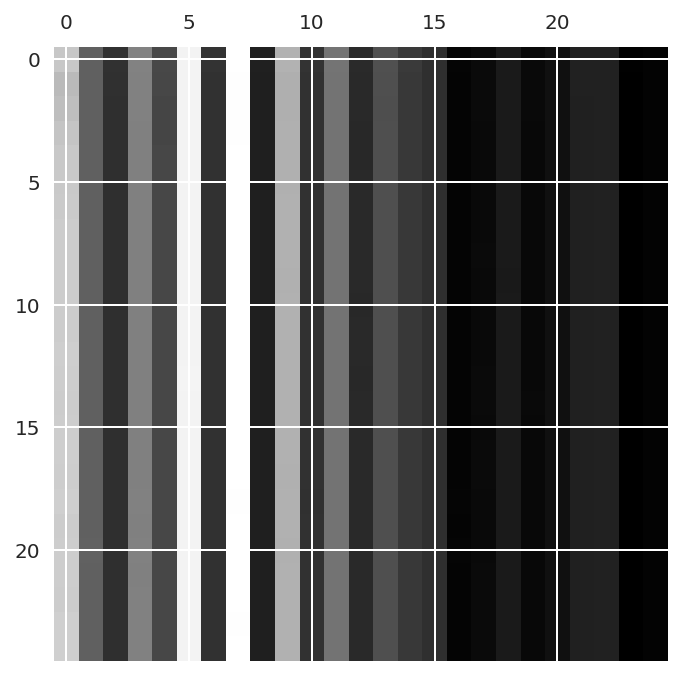

In [173]:
plt.matshow(torch.stack(atts)[:,2,:].detach().cpu().numpy())